<a href="https://colab.research.google.com/github/davidmorme/Universidad/blob/main/Herramientas%20de%20Modelaci%C3%B3n/Caso_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Iniciamos importando las librerías requeridas para el desarrollodo del caso

In [ ]:
#!conda install -y pandas numpy matplotlib
#!conda install -y statsmodels openpyxl

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

Adicionalmente, para este caso necesitaremos instalar la librería statsmodels, para eso debemos abrir el Anaconda Prompt, activar el ambiente del curso, y ejecutar el comando `conda install statsmodels`

# Caso 3: Analizando el Comportamiento Histórico de la Tasa Representativa del Mercado

En este caso se trabajará con dos series de tiempo, la serie de tiempo del histórico de la Tasa Representativa del Mercado (TRM) y la serie de tiempo del histórico de la inflación anual. Aprenderemos a determinar la tendencia de estas series y también a removerla para obtener sólo las variaciones principales. Al final, estableceremos una correlación entre las variaciones y seremos capaces de concluir sobre la influencia de la TRM sobre la inflación.

## Resultado previsto de aprendizaje
Al terminar este caso, el estudiante debe estar en la capacidad de importar datos con Pandas, de agruparlos y promediarlos usando las funciones `groupby` y `rolling`, y de visualizarlos con la librería Matplotlib. También debe estar en capacidad de establecer si una serie de tiempo es estacionaria y de remover tendencias usando promedios móviles.

---

## Contexto del Problema

A usted se le entregarán dos bases de datos con el histórico de la TRM y el histórico de la inflación anual. Su objetivo es transformar estas dos series de tiempo en series de tiempo estacionarias y establecer si existe una correlación entre estas dos variables muy importantes en economìa.

### Cargando los datos
Iniciamos cargando los datos con la información del valor histórico de la Tasa Representatitva del Mercado (TRM) y de la inflación usando los datos obtenidos directamente desde la página del Banco de la República

In [4]:
#Me tocó subirlo a los archivos de Colab
TRM = pd.read_excel('TCM_Serie historica IQY.xlsx', header=7, skipfooter = 4)
IPC = pd.read_excel('IPC_Serie_variaciones.xlsx', header = 12, skipfooter= 6)

Noten que hemos incluido dos argumentos adicionales a esta función para especificar que debemos ignorar algunas filas al principio del archivo (header), y también algunas filas al final (footer). Veamos como lucen las primeras líneas de nuestros DataFrames

In [5]:
TRM.head()

,Fecha (dd/mm/aaaa),Tasa de cambio representativa del mercado (TRM),Unnamed: 2,Unnamed: 3
0,1991-11-27,693.32,NaN,NaN
1,1991-11-28,693.99,NaN,NaN
2,1991-11-29,694.70,NaN,NaN
3,1991-11-30,694.70,NaN,NaN
4,1991-12-01,643.42,NaN,NaN


In [12]:
TRM.drop(['Unnamed: 2','Unnamed: 3'], axis=1, inplace=True)

In [13]:
TRM.head()

,Fecha (dd/mm/aaaa),Tasa de cambio representativa del mercado (TRM)
0,1991-11-27,693.32
1,1991-11-28,693.99
2,1991-11-29,694.70
3,1991-11-30,694.70
4,1991-12-01,643.42


In [14]:
IPC.head()

,Año(aaaa)-Mes(mm),Índice,Inflación anual %,Inflación mensual %,Inflación año corrido %
0,195407,0.03,NaN,NaN,NaN
1,195408,0.03,NaN,-0.76,-0.76
2,195409,0.03,NaN,-1.37,-2.12
3,195410,0.03,NaN,0.34,-1.79
4,195411,0.03,NaN,0.27,-1.52


Veamos los formatos de las columnas:

In [15]:
TRM.dtypes

Fecha (dd/mm/aaaa)                                 datetime64[ns]
Tasa de cambio representativa del mercado (TRM)           float64
dtype: object

El tipo `datetime64` es un tipo de variable nuevo definido por Numpy para manejar formatos de fecha-hora y Pandas lo utiliza cuando detecta que una columna es de tipo fecha-hora. Es siempre una buena práctica trabajar fechas y horas en este formato.

In [16]:
IPC.dtypes

Año(aaaa)-Mes(mm)            int64
Índice                     float64
Inflación anual %          float64
Inflación mensual %        float64
Inflación año corrido %    float64
dtype: object

Observamos  que hay varias diferencias entre nuestros datasets, la primera es que los datos de la TRM tienen una periodicidad diaria, mientras que los datos de inflación tienen una periodicidad mensual. Por otro lado, las fechas en la serie de TRM tienen el formato correcto, mientras que en la base de inflación han sido leídas en el formato equivocado.

### Pasando los datos de TRM a una periodicidad mensual

Lo primero que haremos para poder correlacionar las dos variables será modificar la periodicidad de los datos de TRM de diaria a mensual. Para hacer esto usaremos la siguiente estrategia: tomaremos todos los valores de TRM del mismo mes y los promediaremos. El valor promedio será el que se reporta como resultado del mes.

Ocurre que los nombres de las columnas son muy largos, es una buena práctica renombrar las columnas para que quede clara qué información contienen pero también sea fácil trabajar con esos nombres posteriormente:

In [17]:
TRM.rename(columns = {'Fecha (dd/mm/aaaa)': 'fecha', 'Tasa de cambio representativa del mercado (TRM)': 'TRM'}, inplace = True)

Note como el argumento de la función `drop` es una lista con los nombres de las columnas, mientras que el argumento de la función `rename` es un diccionario con los nombres antiguos como las *keys* y con los nombres nuevos como los *items*.

In [18]:
TRM.head()

,fecha,TRM
0,1991-11-27,693.32
1,1991-11-28,693.99
2,1991-11-29,694.70
3,1991-11-30,694.70
4,1991-12-01,643.42


Para poder promediar los datos por mes, vamos a ahora a crear una nueva columna con la información correspondiente únicamente al mes. Esto es muy fácil usando la función `dt.toperiod()`, veamos:

In [19]:
TRM['mes'] = TRM['fecha'].dt.to_period('M')

TRM.head()

,fecha,TRM,mes
0,1991-11-27,693.32,1991-11
1,1991-11-28,693.99,1991-11
2,1991-11-29,694.70,1991-11
3,1991-11-30,694.70,1991-11
4,1991-12-01,643.42,1991-12


El parámetro `'M'` le dice a la función que queremos la información solo del mes, para obtener información del año usamos `'Y'`, de la semana usamos `'W'`, o del trimestre usamos `'Q'`.

#### La función `groupby`

Como su nombre lo indica, la función `groupby` sirve para agrupar conjuntos de datos que tengan los mismos valores en alguna, o algunas columnas. Sin embargo, el agrupamiento por si solo no es una salida con la que podamos trabajar, es siempre necesario decirle a `gropuby` qué deseamos hacer con los datos, esto es la función de agrupamiento.<br>

La estructura general de la función `groupby` es la siguiente:

`nombre_dataframe.groupby(columna_a_agrupar).funcion_agrupación()`

La Figura siguiente muestra algunos ejemplos de su utilización:

![Picture title](https://github.com/davidmorme/Universidad/blob/main/Herramientas%20de%20Modelaci%C3%B3n/fig/C3_1.png?raw=1)

En nuestro DataFrame todos los objetos correspondientes al mismo mes tienen el mismo valor en la columna `mes`, entonces podemos usar la función `groupby` para calcular el valor promedio de la TRM cada mes.


In [20]:
TRM_mes = TRM.groupby('mes').mean()

TRM_mes.head()

,TRM
mes,
1991-11,694.177500
1991-12,630.412581
1992-01,644.058065
1992-02,635.671724
1992-03,640.501935


Para lo que sigue queremos que la fecha sea una columna, no un índice, entonces usamos la función `'reset_index'`

In [21]:
TRM_mes.reset_index(inplace = True)

TRM_mes.head()

,mes,TRM
0,1991-11,694.177500
1,1991-12,630.412581
2,1992-01,644.058065
3,1992-02,635.671724
4,1992-03,640.501935


### Generando nuestra primera gráfica

Gracias a la integración entre Pandas y Matplotlib es posible generar visualizaciones de forma muy rápida usando la función `plot` de Pandas. Esta función está definida para la clase DataFrame y por lo tanto la podemos llamar de la siguiente manera:

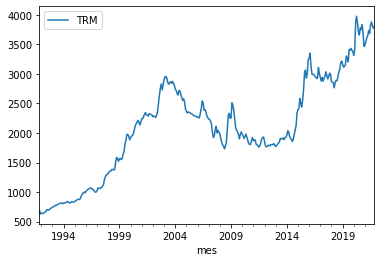

In [22]:
TRM_mes.plot('mes', 'TRM')

El primer argumento de la función `plot` corresponde a la columna que queremos graficar en el eje *x* y el segundo argumento corresponde a la columna que queremos graficar en el eje *y*. 

Es posible modificar muchos parámetros de la gráfica incluyendo argumentos adicionales de configuración:

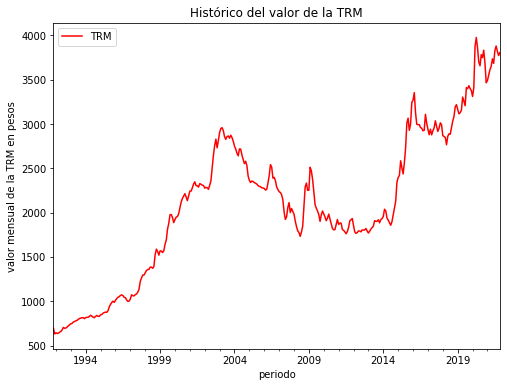

In [23]:
TRM_mes.plot('mes', 'TRM', 
            figsize = (8,6), # cambia el tamaño de la gráfica
            xlabel = 'periodo', # cambia el nombre del eje x
            ylabel = 'valor mensual de la TRM en pesos', # cambia el nombre del eje y
            title = 'Histórico del valor de la TRM', # cambia el título de la gráfica
            color = 'red') # cambia el color de los datos

___
#### Ejercicio 1

Cree un nuevo DataFrame con los promedios anuales de la Tasa Representativa del Mercado. Posteriormente haga una gráfica con los datos obtenidos.

___

#### Ejercicio 2

Calcule para cada mes los valores máximos y mínimos de la Tasa Representativa del Mercado. Posteriormente réstelos para establecer la variación mensual de la TRM, y haga una gráfica de esta variación. ¿Con qué evento coincide la variación máxima observada?

___

### Análisis de Series de Tiempo

Las **series de tiempo** corresponden a datos que han sido recolectados y/o registrados en intervalos de tiempo **regulares** y cuyo comportamiento puede modelarse y predecirse a través de metologías estadísticas.

Con la finalidad de caracterizar series de tiempo, podemos utilizar de manera preliminar gráficas y medidas descriptivas. De acuerdo del comportamiento gráfico de la serie, podemos emplear algunos estadísticos para describirla:

* Cuando la serie fluctúa de forma constante alrededor de algún valor, se puede usar el **promedio de las observaciones** y su **desviación estándar**

- Si la serie tiene un comportamiento creciente o decreciente, podemos usar el **promedio de las tasas de variación** así como sus valores **máximo(s)** y/o **mínimo(s)** a nivel local o global. 



Podemos analizar la variación de una serie de tiempo teniendo en cuenta los elementos siguientes:

- **Tendencia:** indica el _movimiento_ de la serie a largo plazo.
- **Estacionalidad:** permite determinar efectos que se producen de forma periódica.
-  **Aleatoriedad:** caracteriza los elementos aleatorios en la serie.


#### Procesos Estocásticos y Deterministicos

Cuando hablamos de un **proceso estocástico** contamos con un conjunto de _variables aleatorias_ que podemos ordenar de acuedo a algún índice (que usualmente corresponde al tiempo):

$$\{x_t\}=\{...,x_1,x_2,x_3,x_4,...\}$$

Al trabajar con variables aleatorias, es necesario tener en cuenta que no podemos predecir su resultado para cada instante y, en lugar de ello, utilizamos distribuciones de probabilidad para entender su comportamiento.

Como contraparte de un proceso estocástico encontramos los **procesos determinísticos** en donde, sin importar cuántas veces realicemos un experimento, podremos predecir con total certeza el resultado que se obtendrá. Muchas veces sin embargo, cuando no conocemos todas las variables involucradas, podemos abordar un proceso determinístico como uno estocástico.

### Estacionariedad

El proceso estocástico que produce una serie de tiempo puede asociarse con una **distribución de probabilidad** y, cuando ésta no cambia en el tiempo, nos permite hacer inferencia y predecir el comportamiento de la serie con mayor seguridad. Esta característica se conoce como **estacionariedad**.

En resumen, una serie de tiempo es estacionaria si su media y su varianza permanecen constantes en el tiempo y si la serie no tiene una tendencia.

<span style="color:red">**NOTA:** Estacionalidad $\neq$ Estacionariedad</span>.


Claramente, la serie de tiempo de la TRM es no estacionaria ya que tiene una tendencia clara que cambia a lo largo del tiempo. Es difícil identificar para esta serie de tiempo una estacionalidad, ya que no hay patrones repetitivos claros. También es claro que esta serie de tiempo está afectada por fenómenos aleatorios, y de ahí que tenga muchas variaciones de poca frecuencia.

Sin embargo, hay situaciones en las que determinar la estacionariedad de una serie de tiempo no es tan evidente, y por eso se han desarrollado métodos estadísticos que nos pueden dar una estimación de con cuánta seguridad podemos hablar de una serie de tiempo estacionaria.

### Prueba Dickey-Fuller
La prueba Dickey-Fuller es una prueba estadística que nos permite probar la hipótesis nula de que la serie de tiempo es no-estacionaria. Como en todos los procesos de pruebas de hipótesis, el resultado de la prueba será un p-valor que deberemos interpretar de acuerdo con el nivel de significancia que queremos obtener. En general, podemos rechazar que la hipótesis nula, y aceptar entonces que la serie es estacionaria, con un nivel de confianza $\alpha$ si el p-valor satisface:<br>
$$p<1-\alpha$$

Apliquemos la prueba sobre nuestra serie de tiempo de valores de la TRM, para esto usaremos el paquete Statsmodels que como su nombre lo indica contiene muchas aplicaciones en estadística. La información específica de la función utilizada para hacer la prueba Dickey-Fuller puede ser encontrada en la documentación oficial:

https://www.statsmodels.org/dev/generated/statsmodels.tsa.stattools.adfuller.html 

In [25]:
#######
#### REMOVER EN EL NOTEBOOK FINAL
######
!pip install statsmodels

In [26]:
# Prueba de Dickey - Fuller para Estacionariedad
'''
The null hypothesis of the Augmented Dickey-Fuller is that there is a unit root, 
with the alternative that there is no unit root.
'''
from statsmodels.tsa.stattools import adfuller

print('Prueba de Hipótesis Dickey-Fuller:')
dftest = adfuller(TRM_mes['TRM'])
pvalor = dftest[1]  # el segundo elemento de la salida del test es el p-valor
print('p-valor: ', dftest[1])

significancia = 0.95
print('Se puede rechazar la hipótesis nula: ', pvalor<(1-significancia))

Prueba de Hipótesis Dickey-Fuller:
p-valor:  0.8862876691192689
Se puede rechazar la hipótesis nula:  False


No podemos rechazar en este caso la hipótesis nula, eso quiere decir que de acuerdo con la prueba la serie de tiempo es no-estacionaria, como esperábamos

### Obteniendo la tendencia de los datos

Una de las técnicas más utilizadas para eliminar la componente aleatoria de una serie de tiempo es hacer un promedio móvil, esto es, reemplazar cada dato por el promedio de los datos adyacentes tomado a lo largo de una ventana de tiempo que sea mayor a la frecuencia de las componentes aleatorias.

Los promedios móviles se pueden calcular fácilmente con Pandas usando la función `rolling`

In [27]:
# definiremos primero una ventana de tiempo para hacer el promedio móvil
ventana = 6

In [28]:
# calculamos el promedio móvil usando la ventana definida
TRM_mes['TRM'].rolling(ventana).mean().head(10)

0           NaN
1           NaN
2           NaN
3           NaN
4           NaN
5    649.129467
6    643.395099
7    651.187225
8    661.306257
9    671.056722
Name: TRM, dtype: float64

Hagamos la asignación ahora a una nueva columna llamanda `'TRM_prom'`

In [29]:
TRM_mes['TRM_prom'] = TRM_mes['TRM'].rolling(ventana).mean()

Veamos entonces el resultado:

In [30]:
TRM_mes.head(15)

,mes,TRM,TRM_prom
0,1991-11,694.177500,NaN
1,1991-12,630.412581,NaN
2,1992-01,644.058065,NaN
3,1992-02,635.671724,NaN
4,1992-03,640.501935,NaN
5,1992-04,649.955000,649.129467
6,1992-05,659.771290,643.395099
7,1992-06,677.165333,651.187225
8,1992-07,704.772258,661.306257
9,1992-08,694.174516,671.056722


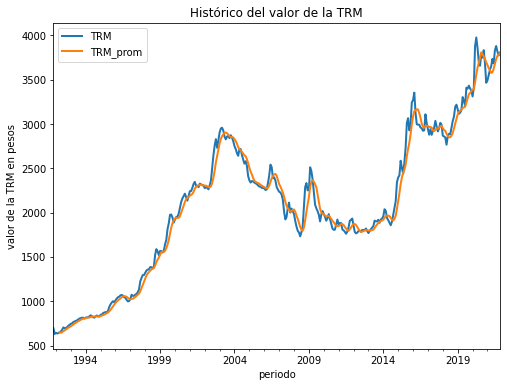

In [31]:
TRM_mes.plot(x='mes', y=['TRM', 'TRM_prom'], figsize = (8,6), # cambia el tamaño de la gráfica
            xlabel = 'periodo', # cambia el nombre del eje x
            ylabel = 'valor de la TRM en pesos', # cambia el nombre del eje y
            title = 'Histórico del valor de la TRM',
            linewidth = 2) # cambia el título de la gráfica


In [39]:
(abs(TRM_mes['TRM']-TRM_mes['TRM_prom'])/TRM_mes['TRM']).mean()

0.03214540520378193

### Aislando la componente aleatoria
Para aislar la componente aleatoria de la serie de tiempo debemos sustraer la tendencia, esto es, debemos sustraer del valor de la TRM el valor promedio. Para cada mes, este valor corresponderá a cuán diferente es la TRM con respecto a la tendencia promedio durante la ventana que se ha establecido.

In [40]:
TRM_mes['TRM_cambio'] = TRM_mes['TRM'] - TRM_mes['TRM_prom']

Grafiquemos ahora cómo luce el cambio de la TRM con respecto al valor promedio:

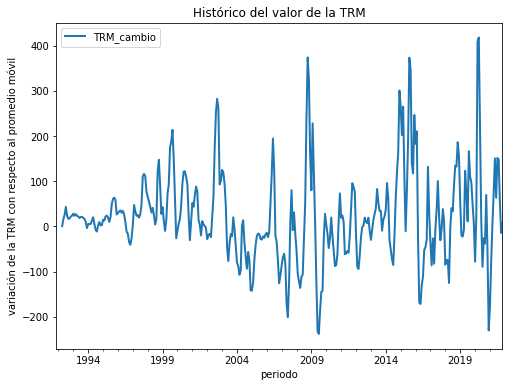

In [41]:
TRM_mes.plot(x='mes', y='TRM_cambio', figsize = (8,6), # cambia el tamaño de la gráfica
            xlabel = 'periodo', # cambia el nombre del eje x
            ylabel = 'variación de la TRM con respecto al promedio móvil', # cambia el nombre del eje y
            title = 'Histórico del valor de la TRM',
            linewidth = 2) # cambia el título de la gráfica

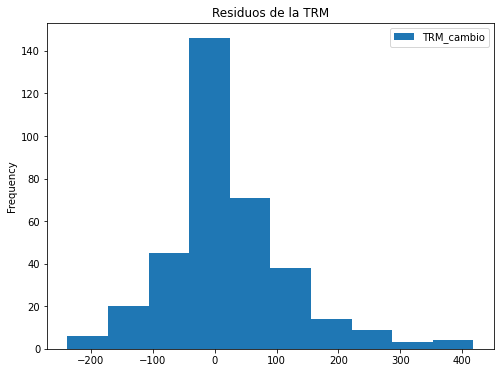

In [45]:
TRM_mes.plot(y='TRM_cambio', kind='hist', figsize = (8,6), # cambia el tamaño de la gráfica
            title = 'Residuos de la TRM',
            linewidth = 2) # cambia el título de la gráfica

Esta serie de variaciones con respecto al promedio ya no tiene una tendencia, sin embargo aún no es estacional debido a que las variaciones aumentan en amplitud a medida que la TRM aumenta en valor. Cuando esto ocurre, una técnica muy efectiva para normalizar las variaciones es transformar los datos usando el logaritmo natural. Para hacer esta transformación usamos el paquete `numpy` que al principio del notebook cargamos como `np`.

In [46]:
# creamos una columna con el logaritmo de la TRM
TRM_mes['TRM_log'] = np.log(TRM_mes['TRM'])  

# calculamos el promedio movil en la ventana definida
TRM_mes['TRM_log_prom'] = TRM_mes['TRM_log'].rolling(ventana).mean() 

# calculamos la diferencia del logaritmo con el promedio movil del logaritmo
TRM_mes['TRM_log_cambio'] = TRM_mes['TRM_log'] - TRM_mes['TRM_log_prom'] 

Creemos ahora una gráfica un poco más compleja con el resultado completo del análisis. Este es un buen ejemplo de cómo crear gráficas más complejas usando tanto matplotlib como pandas.

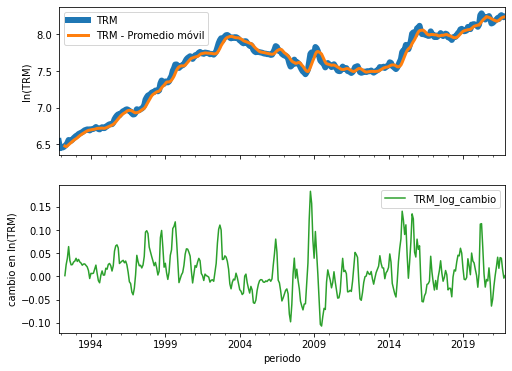

In [49]:
# definimos un elemento figura, y una lista de ejes
fig, axs = plt.subplots(2,1,figsize = (8,6), sharex = True)

# graficos en el eje 0
TRM_mes.plot('mes', 'TRM_log', linestyle='-', linewidth = 6, ax = axs[0])
TRM_mes.plot('mes', 'TRM_log_prom', linestyle='-', linewidth = 3, ax = axs[0])

# graficos en el eje 1
TRM_mes.plot('mes', 'TRM_log_cambio', color = 'C2', ax = axs[1])

# configuración eje 0
axs[0].legend(['TRM','TRM - Promedio móvil']) # fijamos la leyenda
axs[0].set_ylabel('ln(TRM)') # fijamos el nombre del eje y

# configuración eje 1
axs[1].set_xlabel('periodo')  # fijamos el nombre del eje x
axs[1].set_ylabel('cambio en ln(TRM)')

# exportamos la gráfica
plt.savefig('trm_hist.pdf')

Note cómo hemos incluido un comando para exportar la gràfica en el código, ahora la tenemos en un archivo jpg que podemos incrustar en cualquier documentos. El comando `savefig` permite además exportar a formatos como png, pdf, svg. Como vemos, trabajar con el logaritmo natural de la TRM resulta en una nueva serie de tiempo para el cambio diario con respecto al promedio histórico que tiene una varianza mucho más uniforme. Veamos qué resulta cuando se aplica el Dickey-Fuller test a la serie de tiempo de cambios diarios con respecto al promedio móvil del logaritmo natural.

In [50]:
# Prueba de Dickey - Fuller para Estacionariedad
from statsmodels.tsa.stattools import adfuller

print('Prueba de Hipótesis Dickey-Fuller:')
dftest = adfuller(TRM_mes['TRM_log_cambio'].dropna())
pvalor = dftest[1]  # el segundo elemento de la salida del test es el p-valor
print('p-valor: ', dftest[1])

significancia = 0.95
print('Se puede rechazar la hipótesis nula: ', pvalor<(1-significancia))

Prueba de Hipótesis Dickey-Fuller:
p-valor:  1.0861976537137096e-10
Se puede rechazar la hipótesis nula:  True


El valor del p-valor es extremadamente pequeño, de manera que con una altísima confianza podremos rechazar la hipótesis nula y concluir que la serie de tiempo es estacionaria.

La ventaja de usar el logaritmo se evidencia en la siguiente gráfica, que compara la desviación estándar móvil calculada para los datos originales con la desviación estándar móvil calculada para los datos con el logaritmo. En el primer caso hay una clara tendencia al alza en la desviación estándar. Mientras que en el segundo, a pesar de las variaciones, no hay una tendencia clara.

![Picture title](https://github.com/davidmorme/Universidad/blob/main/Herramientas%20de%20Modelaci%C3%B3n/fig/desv_est_movil.png?raw=1)


#### Ejercicio 3
Use la función `rolling(ventana).std()` para calcular, y graficar la desviación estándar móvil de los datos mensuales de la TRM con y sin el logaritmo. Reproduzca la gráfica anterior en la que se compara la desviación estándar móvil en los dos casos.


### Correlación con el IPC

Continuamos nuestro estudio para establecer si existe alguna influencia de la TRM sobre los aumentos de precio en el país. Para arrancar, de nuevo acudiremos al histórico de los datos de inflación que se encuentra en el Banco de la República.

In [52]:
IPC.columns

Index(['Año(aaaa)-Mes(mm)', 'Índice', 'Inflación anual %',
       'Inflación mensual %', 'Inflación año corrido %'],
      dtype='object')

In [53]:
IPC.dtypes

Año(aaaa)-Mes(mm)            int64
Índice                     float64
Inflación anual %          float64
Inflación mensual %        float64
Inflación año corrido %    float64
dtype: object

Renombremos primero las columnas con las que vamos a trabajar

In [55]:
IPC.rename(columns = {'Año(aaaa)-Mes(mm)': 'fecha', 'Inflación anual %' : 'inf_anual'}, inplace = True)
IPC.head()

,fecha,Índice,inf_anual,Inflación mensual %,Inflación año corrido %
0,195407,0.03,NaN,NaN,NaN
1,195408,0.03,NaN,-0.76,-0.76
2,195409,0.03,NaN,-1.37,-2.12
3,195410,0.03,NaN,0.34,-1.79
4,195411,0.03,NaN,0.27,-1.52


Debemos cambiar el formato de la fecha ya que se interpretó como un formato de número flotante, no como un formato año-mes

In [58]:
IPC['mes'] = pd.to_datetime(IPC['fecha'].astype(int).astype(str), format = '%Y%m').dt.to_period('M')
IPC.head()

,fecha,Índice,inf_anual,Inflación mensual %,Inflación año corrido %,mes
0,195407,0.03,NaN,NaN,NaN,1954-07
1,195408,0.03,NaN,-0.76,-0.76,1954-08
2,195409,0.03,NaN,-1.37,-2.12,1954-09
3,195410,0.03,NaN,0.34,-1.79,1954-10
4,195411,0.03,NaN,0.27,-1.52,1954-11


Observemos la evaluación de la inflación acumulada anual a lo largo del tiempo:

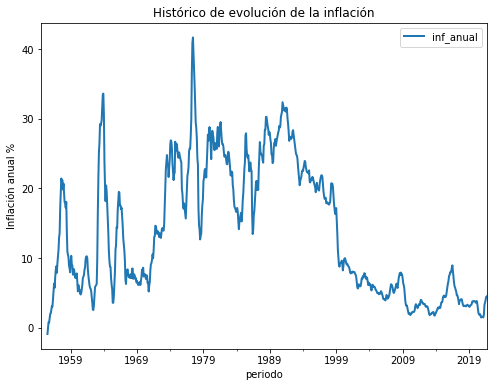

In [59]:
IPC.plot(x='mes', y='inf_anual', figsize = (8,6), # cambia el tamaño de la gráfica
            xlabel = 'periodo', # cambia el nombre del eje x
            ylabel = 'Inflación anual %', # cambia el nombre del eje y
            title = 'Histórico de evolución de la inflación',
            linewidth = 2) # cambia el título de la gráfica

Aplicaremos de nuevo la misma técnica para eliminar la tendencia de esta serie de tiempo

In [61]:
IPC['inf_cambio'] = np.log(IPC['inf_anual'])-np.log(IPC['inf_anual']).rolling(ventana).mean()

/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:726: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [64]:
IPC

,fecha,Índice,inf_anual,Inflación mensual %,Inflación año corrido %,mes,inf_cambio
0,195407,0.03,NaN,NaN,NaN,1954-07,NaN
1,195408,0.03,NaN,-0.76,-0.76,1954-08,NaN
2,195409,0.03,NaN,-1.37,-2.12,1954-09,NaN
3,195410,0.03,NaN,0.34,-1.79,1954-10,NaN
4,195411,0.03,NaN,0.27,-1.52,1954-11,NaN
...,...,...,...,...,...,...,...
803,202106,108.78,3.63,-0.05,3.13,2021-06,0.542935
804,202107,109.14,3.97,0.32,3.47,2021-07,0.481008
805,202108,109.62,4.44,0.45,3.93,2021-08,0.418569
806,202109,110.04,4.51,0.38,4.33,2021-09,0.251847


#### La función `merge`

La función `merge` es muy útil cuando se trata de llevar a un DataFrame la información que se encuentra en otro DataFrame. En ambos DataFrames debe haber una columna común con respecto a la cual se hará la asignación. La Figura siguiente muestra la sintaxis general y el resultado esperado de usar la función `merge`:

![Picture title](https://github.com/davidmorme/Universidad/blob/main/Herramientas%20de%20Modelaci%C3%B3n/fig/C3_3.png?raw=1)

Ahora usamos la función `merge` para unir la información de las variaciones de la TRM, con las variaciones de la inflación.

In [63]:
TRM_mes

,mes,TRM,TRM_prom,TRM_cambio,TRM_log,TRM_log_prom,TRM_log_cambio
0,1991-11,694.177500,NaN,NaN,6.542728,NaN,NaN
1,1991-12,630.412581,NaN,NaN,6.446374,NaN,NaN
2,1992-01,644.058065,NaN,NaN,6.467789,NaN,NaN
3,1992-02,635.671724,NaN,NaN,6.454682,NaN,NaN
4,1992-03,640.501935,NaN,NaN,6.462252,NaN,NaN
...,...,...,...,...,...,...,...
356,2021-07,3829.418065,3678.029256,151.388809,8.250468,8.209847,0.040621
357,2021-08,3881.183548,3732.475799,148.707749,8.263895,8.224501,0.039394
358,2021-09,3821.537667,3767.270679,54.266987,8.248408,8.233864,0.014544
359,2021-10,3773.384194,3787.705378,-14.321185,8.235728,8.239370,-0.003642


In [65]:
TRM_mes = TRM_mes.merge(IPC[['mes','inf_cambio']], on = 'mes', how = 'left')

In [66]:
TRM_mes.head()

,mes,TRM,TRM_prom,TRM_cambio,TRM_log,TRM_log_prom,TRM_log_cambio,inf_cambio
0,1991-11,694.177500,NaN,NaN,6.542728,NaN,NaN,-0.067470
1,1991-12,630.412581,NaN,NaN,6.446374,NaN,NaN,-0.094213
2,1992-01,644.058065,NaN,NaN,6.467789,NaN,NaN,-0.048137
3,1992-02,635.671724,NaN,NaN,6.454682,NaN,NaN,-0.029107
4,1992-03,640.501935,NaN,NaN,6.462252,NaN,NaN,-0.021906


Grafiquemos ahora las dos series de tiempo en paralelo.

Text(0, 0.5, 'cambio en ln(inf_anual)')

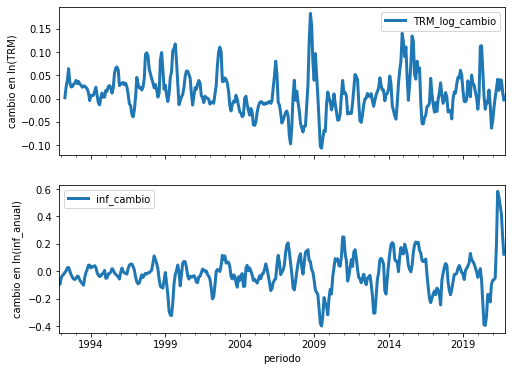

In [67]:
# definimos un elemento figura, y una lista de ejes
fig, axs = plt.subplots(2,1,figsize = (8,6), sharex = True)

# graficos en el eje 0
TRM_mes.plot('mes', 'TRM_log_cambio', linestyle='-', linewidth = 3, ax = axs[0])
TRM_mes.plot('mes', 'inf_cambio', linestyle='-', linewidth = 3, ax = axs[1])


# configuración eje 0
axs[0].set_ylabel('cambio en ln(TRM)') # fijamos el nombre del eje y

# configuración eje 1
axs[1].set_xlabel('periodo')  # fijamos el nombre del eje x
axs[1].set_ylabel('cambio en ln(inf_anual)')

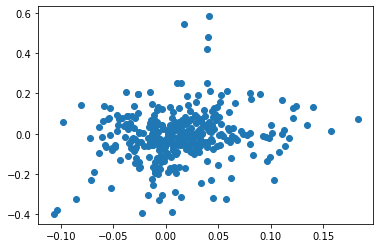

In [70]:
fig, ax =plt.subplots()
ax.scatter(TRM_mes['TRM_log_cambio'],TRM_mes['inf_cambio'])
fig.show()

#### Correlación de Pearson
Formalmente la Correlación de Pearon es una medida de la Covarianza entre dos series de datos. Esto quiere decir que es una medida de qué tanto se relacionan linealmente las dos series. En series de tiempo perfectamente correlacionados, la Correlación de Pearson es 1 o -1. En el primer caso el signo positivo implica que aumentos en una serie siempre están acompañados de aumentos en la segunda, en el segundo caso el signo negativo implica que aumentos en la primera serie siempre conllevan a disminuciones en la segunda. Si no existe ninguna correlación entre dos series, entonces la Correlación de Pearson es 0.

Podemos ahora calcular la correlación de Pearson existente entre las dos series de tiempo. 

In [71]:
TRM_mes['TRM_log_cambio'].corr(TRM_mes['inf_cambio'])

0.19002322554079806

Se obtiene un porcentaje de correlación de alrededor del 19%, que es significativo y es positivo. Lo que implica que aumentos en la TRM usualmente coinciden con aumentos en la inflación. Sin embargo, vale la pena estudiar la correlación retrasada o adelanta en el tiempo de una variable con respecto a la otra.

In [84]:
TRM_mes['TRM_log_cambio']

0           NaN
1           NaN
2           NaN
3           NaN
4           NaN
         ...   
356    0.040621
357    0.039394
358    0.014544
359   -0.003642
360    0.001979
Name: TRM_log_cambio, Length: 361, dtype: float64

In [86]:
TRM_mes['TRM_log_cambio'].shift(1)

0           NaN
1           NaN
2           NaN
3           NaN
4           NaN
         ...   
356    0.017596
357    0.040621
358    0.039394
359    0.014544
360   -0.003642
Name: TRM_log_cambio, Length: 361, dtype: float64

In [72]:
for i in np.arange(-6,6):
    corr = TRM_mes['TRM_log_cambio'].shift(i).corr(TRM_mes['inf_cambio'])
    print (i, ' : ', corr)

-6  :  0.07994930706688462
-5  :  0.04214088912223834
-4  :  0.025557248535927203
-3  :  0.04558795926316772
-2  :  0.09371486073168847
-1  :  0.14746002137389136
0  :  0.19002322554079806
1  :  0.20090632191106061
2  :  0.1564644816955333
3  :  0.08180548282592941
4  :  0.009426239203351271
5  :  -0.0327394778774498


La correlación se maximiza cuando hay un shift de entre 0 y 1 mes, esto sugiere que la inflación responde a los cambios en TRM (y no al revés) y que los cambios en la TRM demoran alrededor de un mes en tener una influencia significativa sobre la inflación.

La maxima correlación es de 20.0%, lo que implica que efectivamente la inflación no está determinada únicamente por las variaciones en la TRM. Nuestro análisis sin embargo sugiere que sí existe una influencia y nos permite estimar el tamaño de la influencia y estimar también el retraso de los efectos.

___

#### Ejercicio 4
Calcule la correlación existente entre las columnas `TRM` y `TRM_log` en el DataFrame `TRM_mes`. ¿Se espera una correlación alta o baja?

___

## Conclusiones

Hemos aprendido a trabajar con DataFrames para agrupar los datos y sacar promedios, y también para juntar información procedente de DataFrames diferentes. Hemos aprendido cómo determinar la tendencia de una serie de tiempo usando promedios móviles y también a aislar la componente aleatoria removiendo la tendencia. También hemos aprendido sobre la prueba Dickey-Fuller para determinar estacionariedad y sobre la correlación de Pearson para establecer correlación entre series de tiempo.

### Origen de los datos
* Valor histórico de la TRM <br>
https://www.banrep.gov.co/es/estadisticas/trm 
* Indice de Precios al Consumidor - IPC <br>
https://www.banrep.gov.co/es/estadisticas/indice-precios-consumidor-ipc

#### Ejercicio 1 - Posible Respuesta

In [ ]:
# creamos una columna con la información del año
TRM['año'] = TRM['fecha'].dt.to_period('Y')

# creamos un nuevo DataFrame con el promedio sobre todos los años
TRM_año = TRM.groupby('año').mean().reset_index()

# creamos la gráfica
TRM_año.plot('año', 'TRM', 
            figsize = (8,6), # cambia el tamaño de la gráfica
            xlabel = 'año', # cambia el nombre del eje x
            ylabel = 'valor anual de la TRM en pesos', # cambia el nombre del eje y
            title = 'Histórico del valor de la TRM', # cambia el título de la gráfica
            color = 'red') # cambia el color de los datos

#### Ejercicio 2 - Posible Respuesta


In [ ]:
# como ya tenemos una columna con la información del mes, podemos arrancar con el groupby de una vez
TRM_max = TRM.groupby('mes').max().reset_index()
TRM_min = TRM.groupby('mes').min().reset_index()

# Ahora restamos los valores máximos y mínimos y los asignamos a una nueva columna en TRM_max
TRM_max['variacion'] = TRM_max['TRM']-TRM_min['TRM']

# Finalmente graficamos
TRM_max.plot('mes', 'variacion', 
            figsize = (8,6), # cambia el tamaño de la gráfica
            xlabel = 'periodo', # cambia el nombre del eje x
            ylabel = 'variación mensual de la TRM en pesos', # cambia el nombre del eje y
            title = 'Variación mensual de la TRM', # cambia el título de la gráfica
            color = 'red') # cambia el color de los datos

#### Ejercicio 3 - Posible Respuesta

In [ ]:
# calculamos la desviación estándar móvil para los datos sin logaritmo
TRM_mes['TRM_std'] = TRM_mes['TRM'].rolling(ventana).std()

# calculamos la desviación estándar móvil para los datos con logaritmo
TRM_mes['TRM_log_std'] = TRM_mes['TRM_log'].rolling(ventana).std()

# Ahora hacemos la gráfica
# definimos un elemento figura, y una lista de ejes
fig, axs = plt.subplots(2,1,figsize = (8,6), sharex = True)

# graficos en el eje 0
TRM_mes.plot('mes', 'TRM_std', linestyle='-', linewidth = 3, ax = axs[0], color = 'C1')

# graficos en el eje 1
TRM_mes.plot('mes', 'TRM_log_std', linestyle='-', linewidth = 3, ax = axs[1], color = 'C2')


# configuración eje 0
axs[0].legend(['TRM','TRM - Promedio móvil']) # fijamos la leyenda
axs[0].set_ylabel('desv_est movil') # fijamos el nombre del eje y

# configuración eje 1
axs[1].set_xlabel('periodo')  # fijamos el nombre del eje x
axs[1].set_ylabel('desv_est movil')


#### Ejercicio 4 - Posible Respuesta

In [ ]:
TRM_mes['TRM'].corr(TRM_mes['TRM_log'])

Debido a que las dos columnas están relacionadas por una función creciente, como el logaritmo natural, se espera que haya una correlación muy alta entre las dos.